## Object Detection

### 이미지에 바운딩 박스 그리기

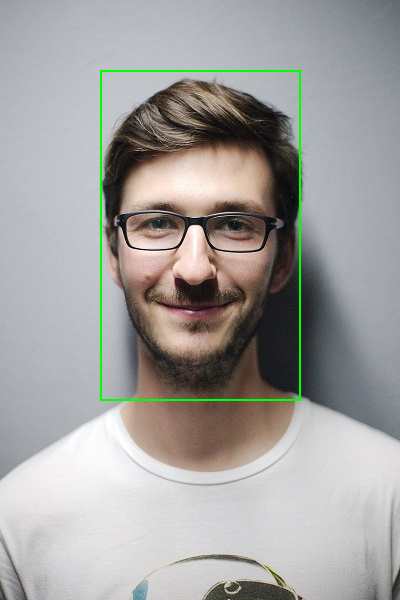

In [1]:
from PIL import Image, ImageDraw
import os

img_path='./images/person.jpeg'
img = Image.open(img_path)

draw = ImageDraw.Draw(img)
draw.rectangle((100, 70, 300, 400), outline=(0,255,0), width=2) # 얼굴에 바운딩 박스 그리기

img

### 간단한 localization 모델

In [4]:
import tensorflow as tf
from tensorflow import keras

output_num = 1+4+3 # object_prob 1, bbox coord 4, class_prob 3

input_tensor = keras.layers.Input(shape=(224, 224, 3), name='image')
base_model = keras.applications.resnet.ResNet50(
    input_tensor=input_tensor,
    include_top=False,    
    weights='imagenet',
    pooling=None,
)
x = base_model.output
preds = keras.layers.Conv2D(output_num, 1, 1)(x)
localize_model = keras.Model(inputs=base_model.input, outputs=preds)

localize_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['image[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### 1) Sliding Window 방식을 이용한 객체 탐지

https://youtu.be/5e5pjeojznk 참고

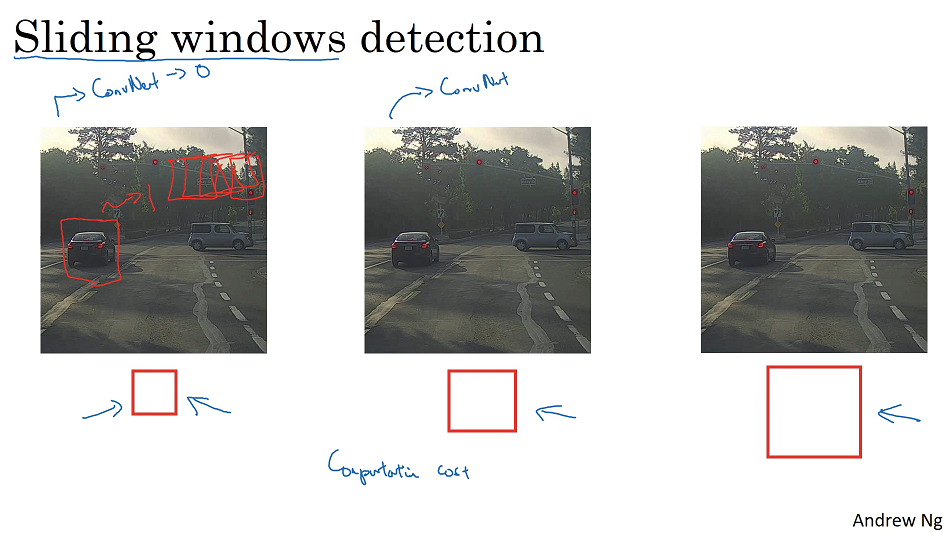

In [6]:
from IPython.display import Image
Image(filename='capture/sliding_window_detection.png') 

이 방식의 단점은
- 슬라이딩 간격을 넓게 하면 정밀하게 탐지하지 못한다는 것과
- Computational cost 가 높다는 것이다.

### 2) Convolution 을 이용해서 Sliding Windows 효과 구현

https://youtu.be/XdsmlBGOK-k 참고

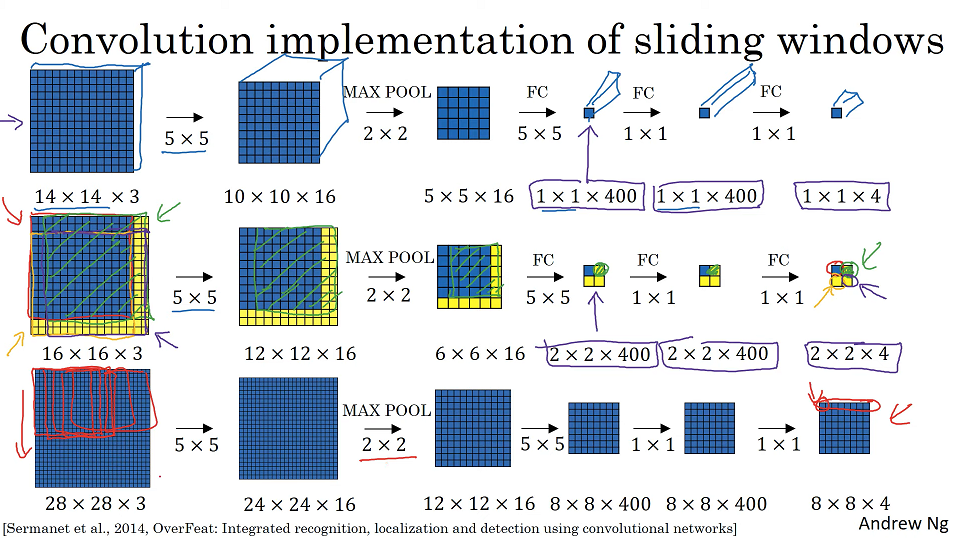

In [9]:
from IPython.display import Image
Image(filename='capture/conv_implementation_of_sliding_windows.png') 

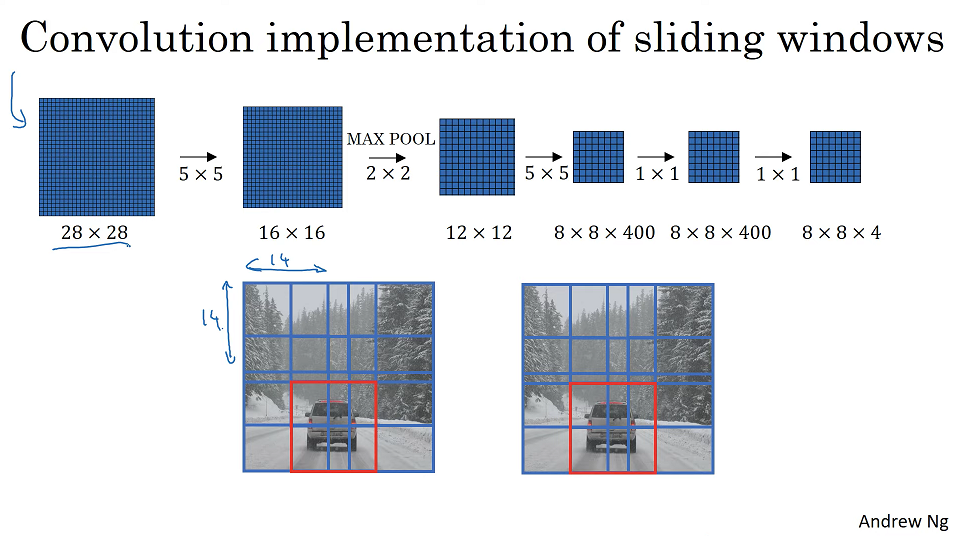

In [10]:
from IPython.display import Image
Image(filename='capture/conv_implementation_of_sliding_windows_2.png') 

하지만 이 방식에도 단점이 있다.  
- 바로 경계가 모호하다는 점이다.

### 3) Anchbor Box (앵커 박스)

https://youtu.be/RTlwl2bv0Tg 참고

앵커박스는 두 물체가 한 격자 셀에 나타날 경우를 다루는 방식이다. highest IOU 로 둘 중 하나가 있다고 결정한다.

한 격자 셀에 두 물체가 동일한 IOU 를 가지는 경우는 거의 없거나,  
있다고 해도 (3x3 격자 대신 19x19 격자 사용 시 간혹 있음) 크게 성능에 영향을 주지 않을 것이다.

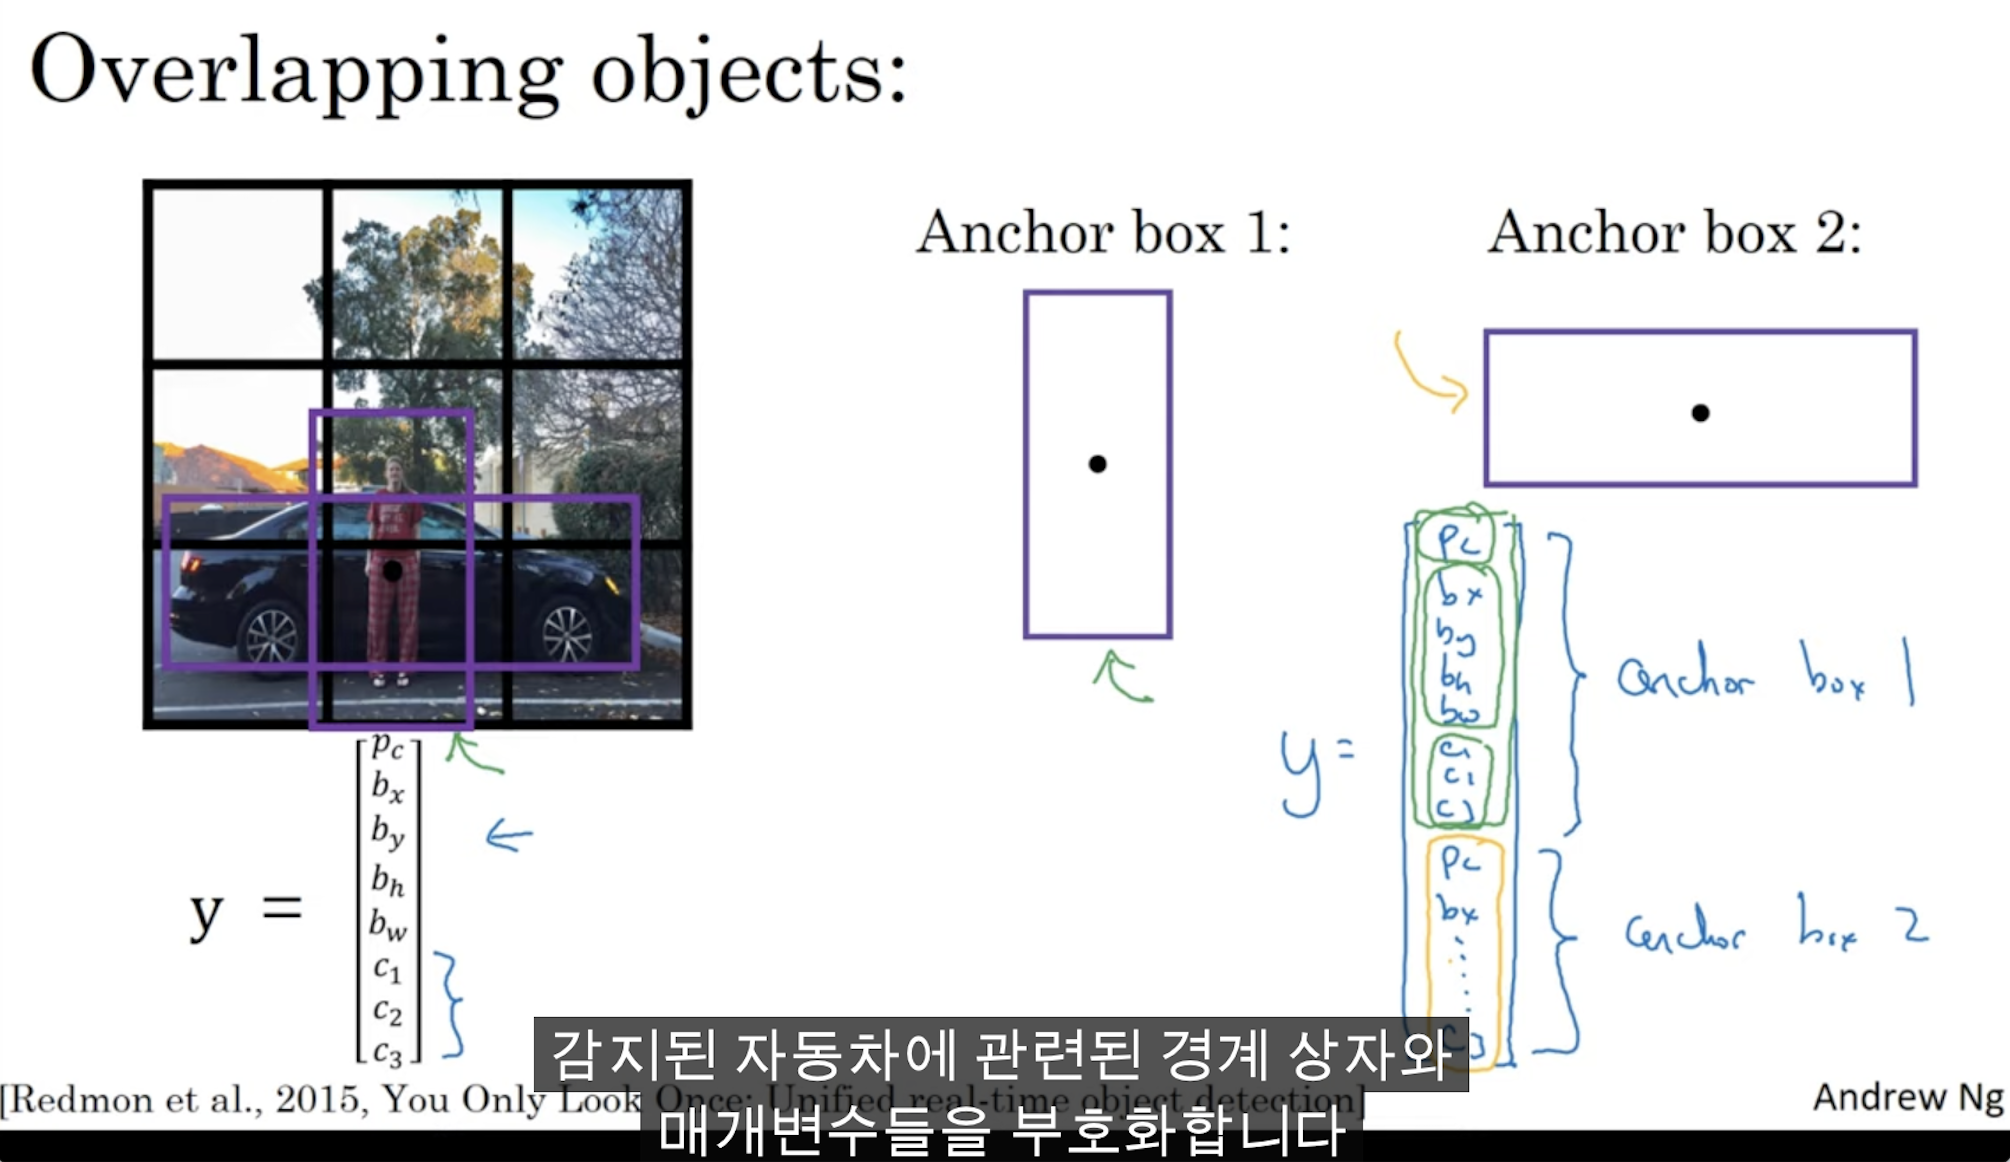

In [5]:
from IPython.display import Image

Image(filename='capture/anchor_box_introduction.png') 

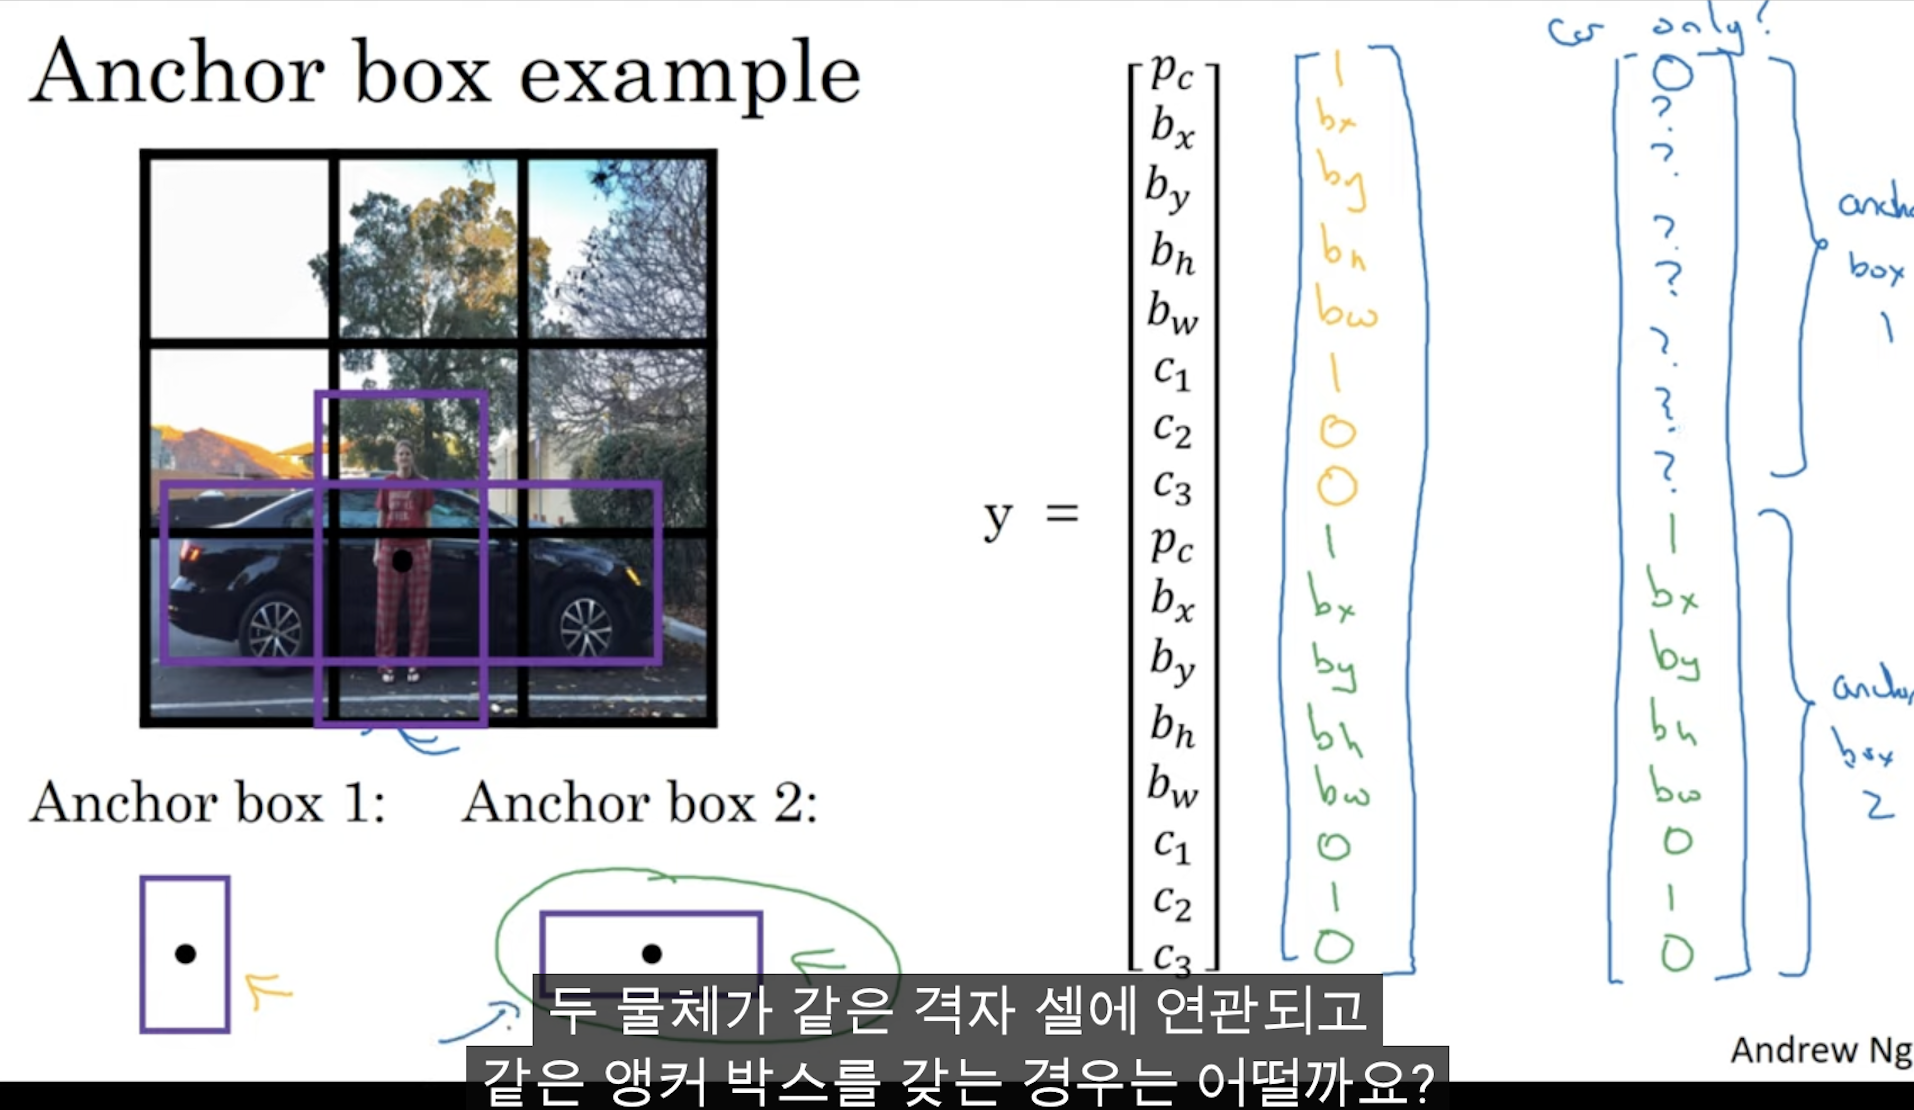

In [3]:
from IPython.display import Image
Image(filename='capture/anchor_box_example.png') 

4 x 4 grid output 에 각 셀마다 9개씩 anchor box 를 사용할때, output 의 dimention 은

우선 anchor box 의 dimention 계산 => 9x(anchor box 차원) == 9 x (pc, bx, by, bh, bw, c1, c2) == 9 x 7
- grid 셀마다 이므로 [None, 4, 4, 9 x 7]
- 배치 단위로 하니깐 [Batch, 4, 4, 9 x 7]

### 4) NMS (Non-Max Suppression)

이전까지 설명한 기법들의 단점은, 같은 물체를 여러번 감지한다는 것이다.  

이 NMS 기법은 각 물체를 한번만 감지하도록 보장해주는 기법이다.

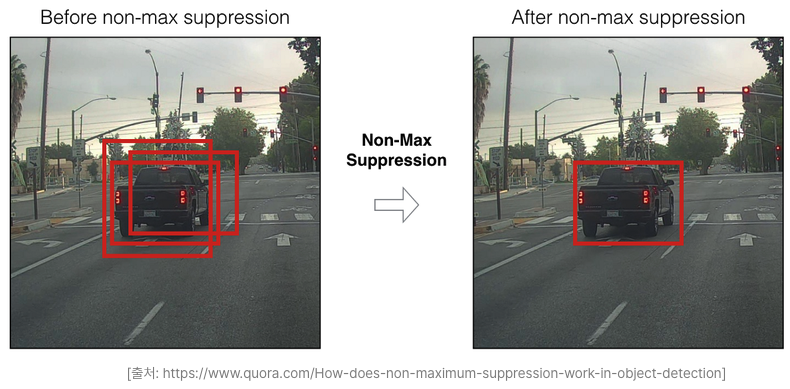

In [6]:
from IPython.display import Image
Image(filename='capture/nms_work.png') 

## Detection Architecture

Two-Stage Detector
- https://youtu.be/6ykvU9WuIws 참고
- https://medium.com/codex/a-guide-to-two-stage-object-detection-r-cnn-fpn-mask-r-cnn-and-more-54c2e168438c 참고

One-Stage Detector
- YOLO
  - https://youtu.be/9s_FpMpdYW8 참고
- SSD
  - 논문 리뷰: https://herbwood.tistory.com/15

### YOLO

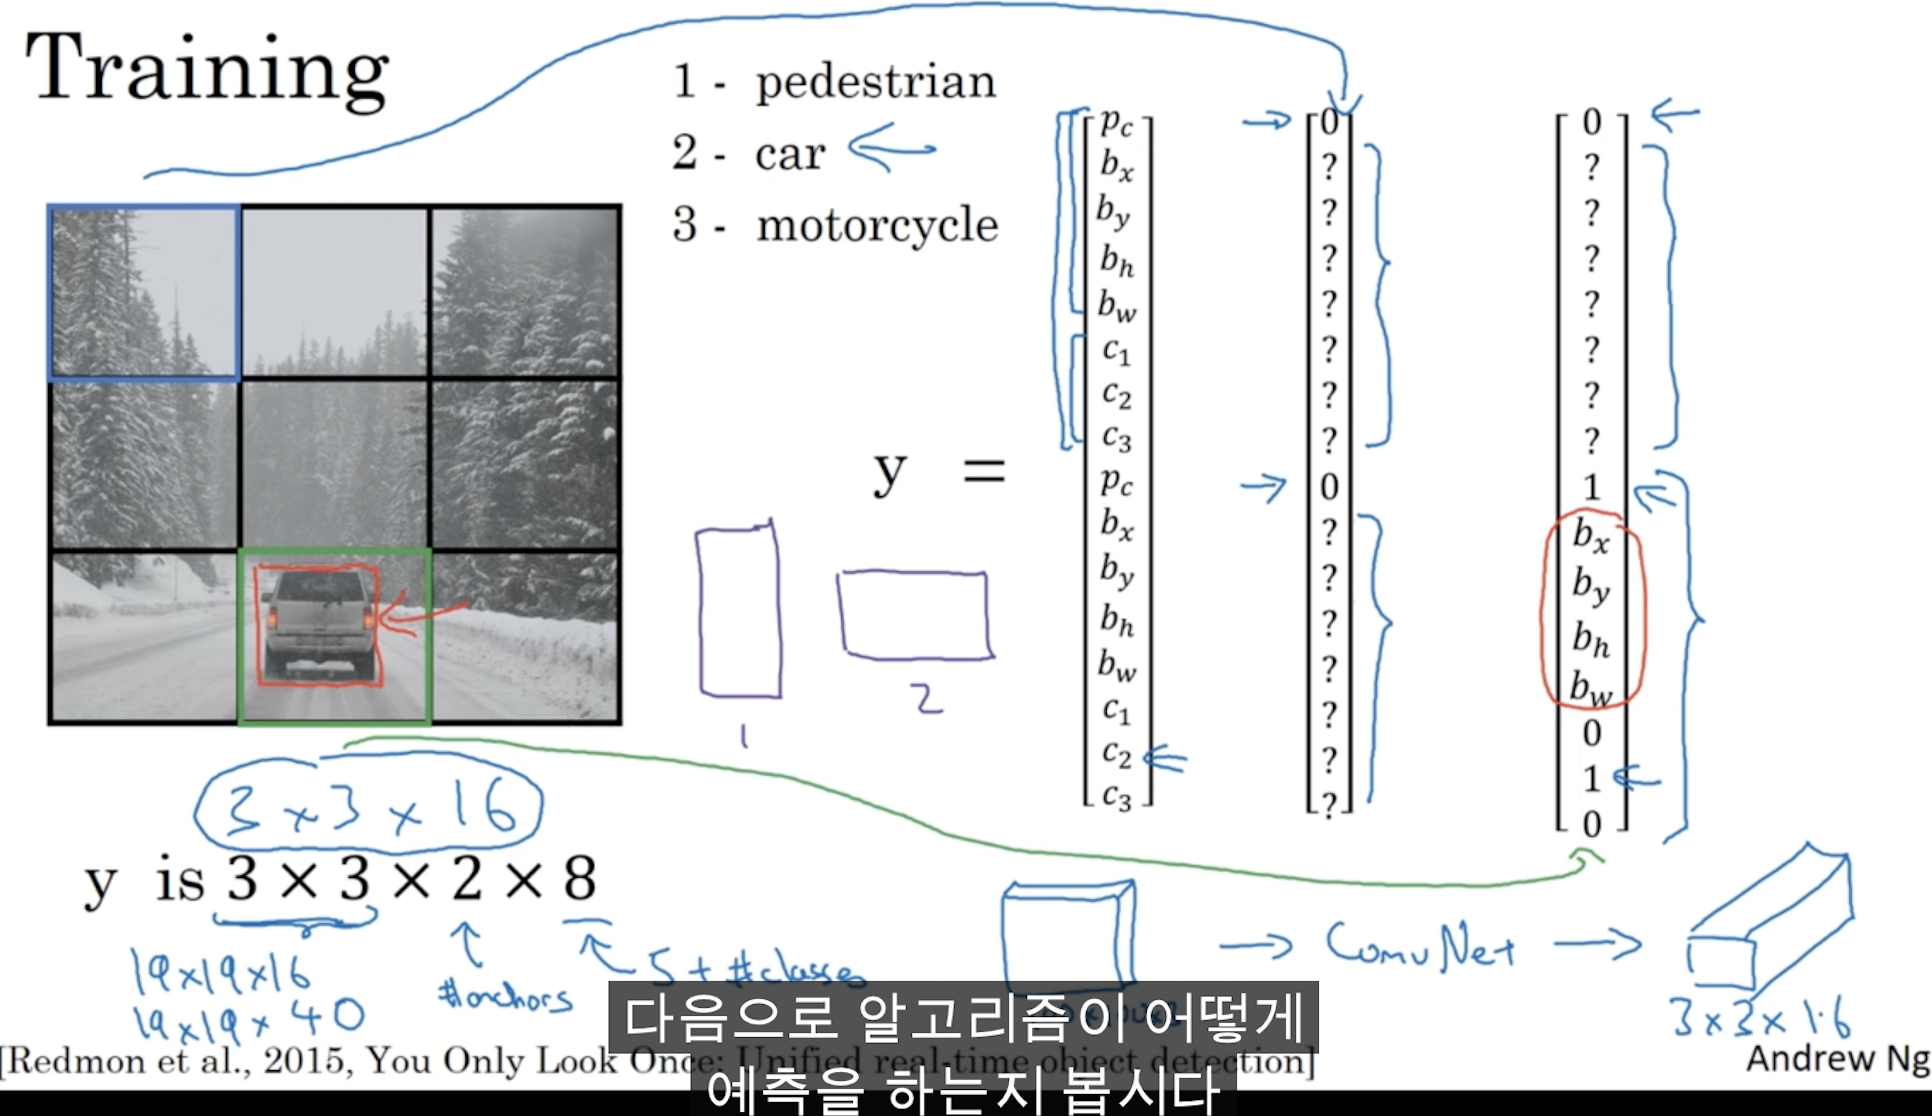

In [7]:
from IPython.display import Image
Image(filename='capture/yolo_algorithm_1.png') 

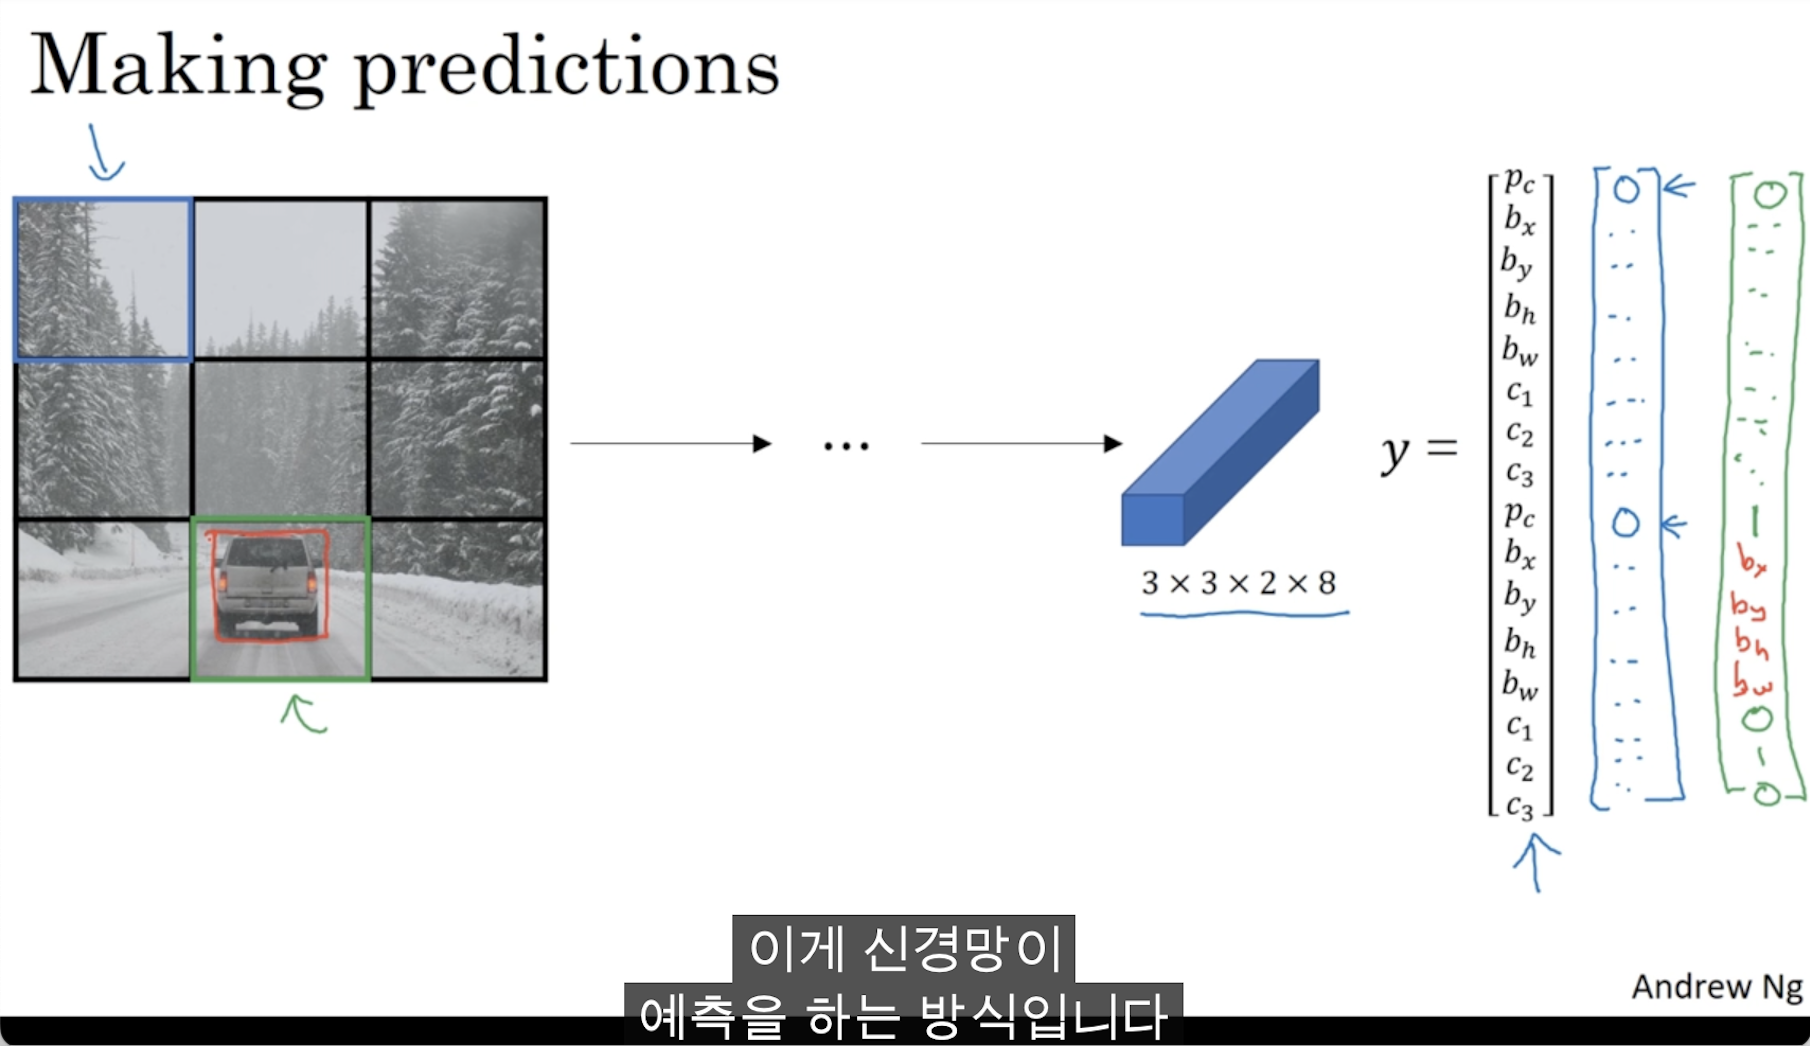

In [8]:
from IPython.display import Image
Image(filename='capture/yolo_algorithm_2.png') 

- 각각에 셀에 대해서 2개씩 bounding box 를 예측한다.
- 그리고 그 box 에 객체가 있든 없든지 상관없이 낮은 확률값을 가진 것들을 제거한다.
- 남은 박스들에 대해서 #class 만큼 NMS 를 수행한다.
  - 예를 들면, car/motocycle/bird 이렇게 3개 클래스가 있을 경우 3번 NMS 를 한다.
  - car 에 해당하는 box 들끼리 NMS, motocycle 에 해당하는 box 들끼리 NMS, bird 에 해당하는 box 들끼리 NMS  

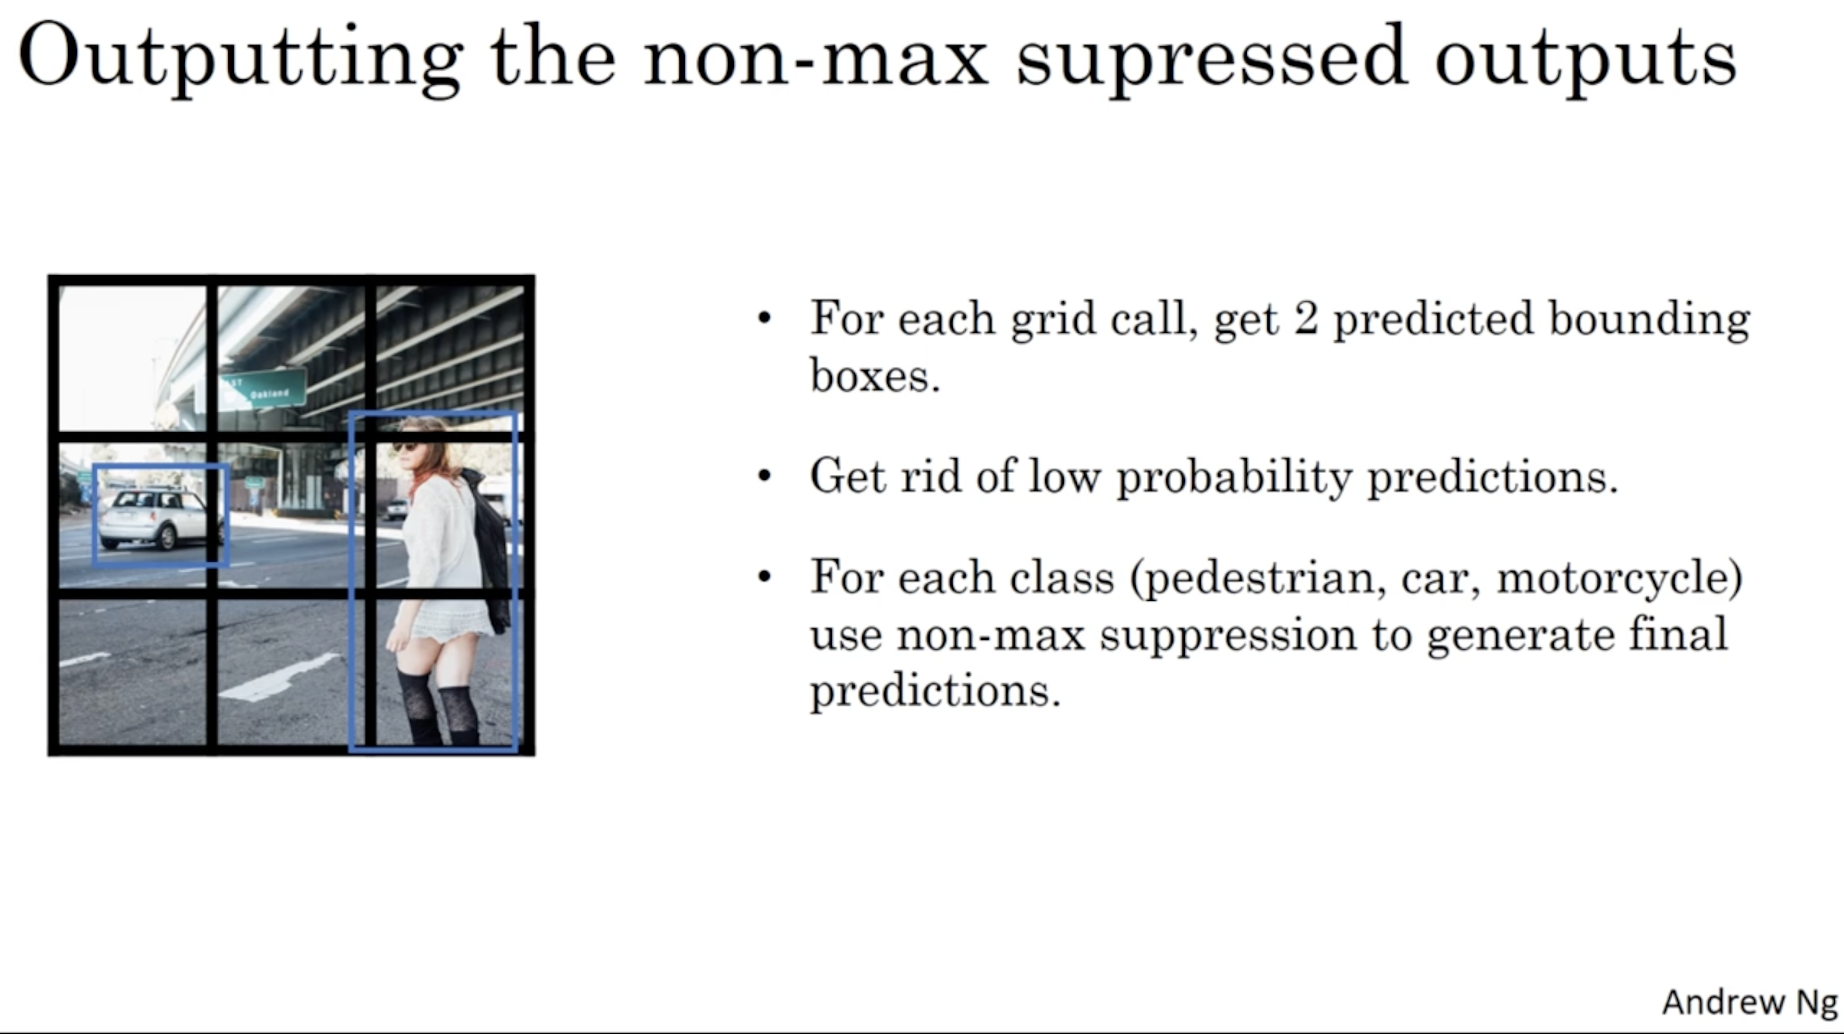

In [9]:
from IPython.display import Image
Image(filename='capture/yolo_algorithm_3.png') 

### Anchor

YOLO와 Faster-RCNN에서 Anchor를 기반으로 Loss를 계산하는 방식에는 두 가지 Intersection over Union(IoU)를 threshold로 사용한다.
- Background IoU threshold
- Foreground IoU threshold

예를 들면
- 객체와의 IoU가 0.7이상일 경우 Foreground로 할당하고 0.3 이하일 경우는 배경(Background)으로 할당
- 대신 0.3과 0.7 중간인 Anchor들은 불분명한 영역으로 학습에 활용하지 않는다.

object 의 크기에 맞게 Anchor boxd 의 크기나 aspect ratio 를 조정해 주어야 함

만약 세로로 긴 물체를 주로 탐지해야 하면, 세로로 긴 Anchor Box 를 많이 만들어야 학습이 잘 될 수 있음

#### Bouding box Regression

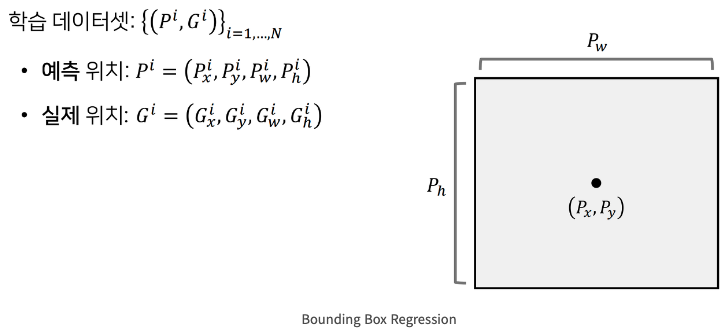

In [11]:
from IPython.display import Image
Image(filename='capture/bounding_box_regression.png') 

배경인 경우에는 Regresson loss 에 반영되지 않는다.

객체가 있는 경우에 Anchor box 와 정답 bounding box 과 연관지어  
얼마나 x 축 또는 y 축으로 옮길지, 그리고 크기를 얼마나 조절해야 하는지를 예측하는 과정이다.